<a href="https://colab.research.google.com/github/Ravimk07/Image_Segmentation/blob/master/Fast_Scnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 85kB/s 
     |████████████████████████████████| 3.0MB 16.4MB/s 
     |████████████████████████████████| 419kB 48.1MB/s 
     |████████████████████████████████| 61kB 23.5MB/s 


In [0]:
import tensorflow as tf

In [3]:
print(tf.__version__)

2.0.0-alpha0


In [0]:
input_layer = tf.keras.layers.Input(shape=(2048, 1024, 3), name = 'input_layer')

In [0]:
def conv_block(inputs, conv_type, kernel, kernel_size, strides, padding='same', relu=True):
  
  if(conv_type == 'ds'):
    x = tf.keras.layers.SeparableConv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)
  else:
    x = tf.keras.layers.Conv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)  
  
  x = tf.keras.layers.BatchNormalization()(x)
  
  if (relu):
    x = tf.keras.activations.relu(x)
  
  return x

In [0]:
lds_layer = conv_block(input_layer, 'conv', 32, (3, 3), strides = (2, 2))
lds_layer = conv_block(lds_layer, 'ds', 48, (3, 3), strides = (2, 2))
lds_layer = conv_block(lds_layer, 'ds', 64, (3, 3), strides = (2, 2))

In [0]:
def _res_bottleneck(inputs, filters, kernel, t, s, r=False):
    
    tchannel = tf.keras.backend.int_shape(inputs)[-1] * t

    x = conv_block(inputs, 'conv', tchannel, (1, 1), strides=(1, 1))

    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = conv_block(x, 'conv', filters, (1, 1), strides=(1, 1), padding='same', relu=False)

    if r:
        x = tf.keras.layers.add([x, inputs])
    return x

In [0]:
def bottleneck_block(inputs, filters, kernel, t, strides, n):
  x = _res_bottleneck(inputs, filters, kernel, t, strides)
  
  for i in range(1, n):
    x = _res_bottleneck(x, filters, kernel, t, 1, True)

  return x

In [0]:
gfe_layer = bottleneck_block(lds_layer, 64, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 96, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 128, (3, 3), t=6, strides=1, n=3)

In [0]:
def pyramid_pooling_block(input_tensor, bin_sizes):
  concat_list = [input_tensor]
  w = 64
  h = 32

  for bin_size in bin_sizes:
    x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
    x = tf.keras.layers.Conv2D(128, 3, 2, padding='same')(x)
    x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w,h)))(x)

    concat_list.append(x)

  return tf.keras.layers.concatenate(concat_list)

In [0]:
gfe_layer = pyramid_pooling_block(gfe_layer, [2,4,6,8])

In [0]:
ff_layer1 = conv_block(lds_layer, 'conv', 128, (1,1), padding='same', strides= (1,1), relu=False)

In [0]:
ff_layer2 = tf.keras.layers.UpSampling2D((4, 4))(gfe_layer)
ff_layer2 = tf.keras.layers.DepthwiseConv2D(128, strides=(1, 1), depth_multiplier=1, padding='same')(ff_layer2)
ff_layer2 = tf.keras.layers.BatchNormalization()(ff_layer2)
ff_layer2 = tf.keras.activations.relu(ff_layer2)
ff_layer2 = tf.keras.layers.Conv2D(128, 1, 1, padding='same', activation=None)(ff_layer2)

In [0]:
ff_final = tf.keras.layers.add([ff_layer1, ff_layer2])
ff_final = tf.keras.layers.BatchNormalization()(ff_final)
ff_final = tf.keras.activations.relu(ff_final)

In [0]:
classifier = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv1_classifier')(ff_final)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.activations.relu(classifier)

classifier = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv2_classifier')(classifier)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.activations.relu(classifier)

classifier = conv_block(classifier, 'conv', 19, (1, 1), strides=(1, 1), padding='same', relu=True)

classifier = tf.keras.layers.Dropout(0.3)(classifier)

classifier = tf.keras.layers.UpSampling2D((8, 8))(classifier)
classifier = tf.keras.activations.softmax(classifier)

In [0]:
fast_scnn = tf.keras.Model(inputs = input_layer , outputs = classifier, name = 'Fast_SCNN')

In [0]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9, lr=0.045)
fast_scnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [19]:
fast_scnn.summary()

Model: "Fast_SCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 2048, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 512, 32 896         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 1024, 512, 32 128         conv2d[0][0]                     
__________________________________________________________________________________________________
Relu (TensorFlowOpLayer)        [(None, 1024, 512, 3 0           batch_normalization_v2[0][0]     
__________________________________________________________________________________________

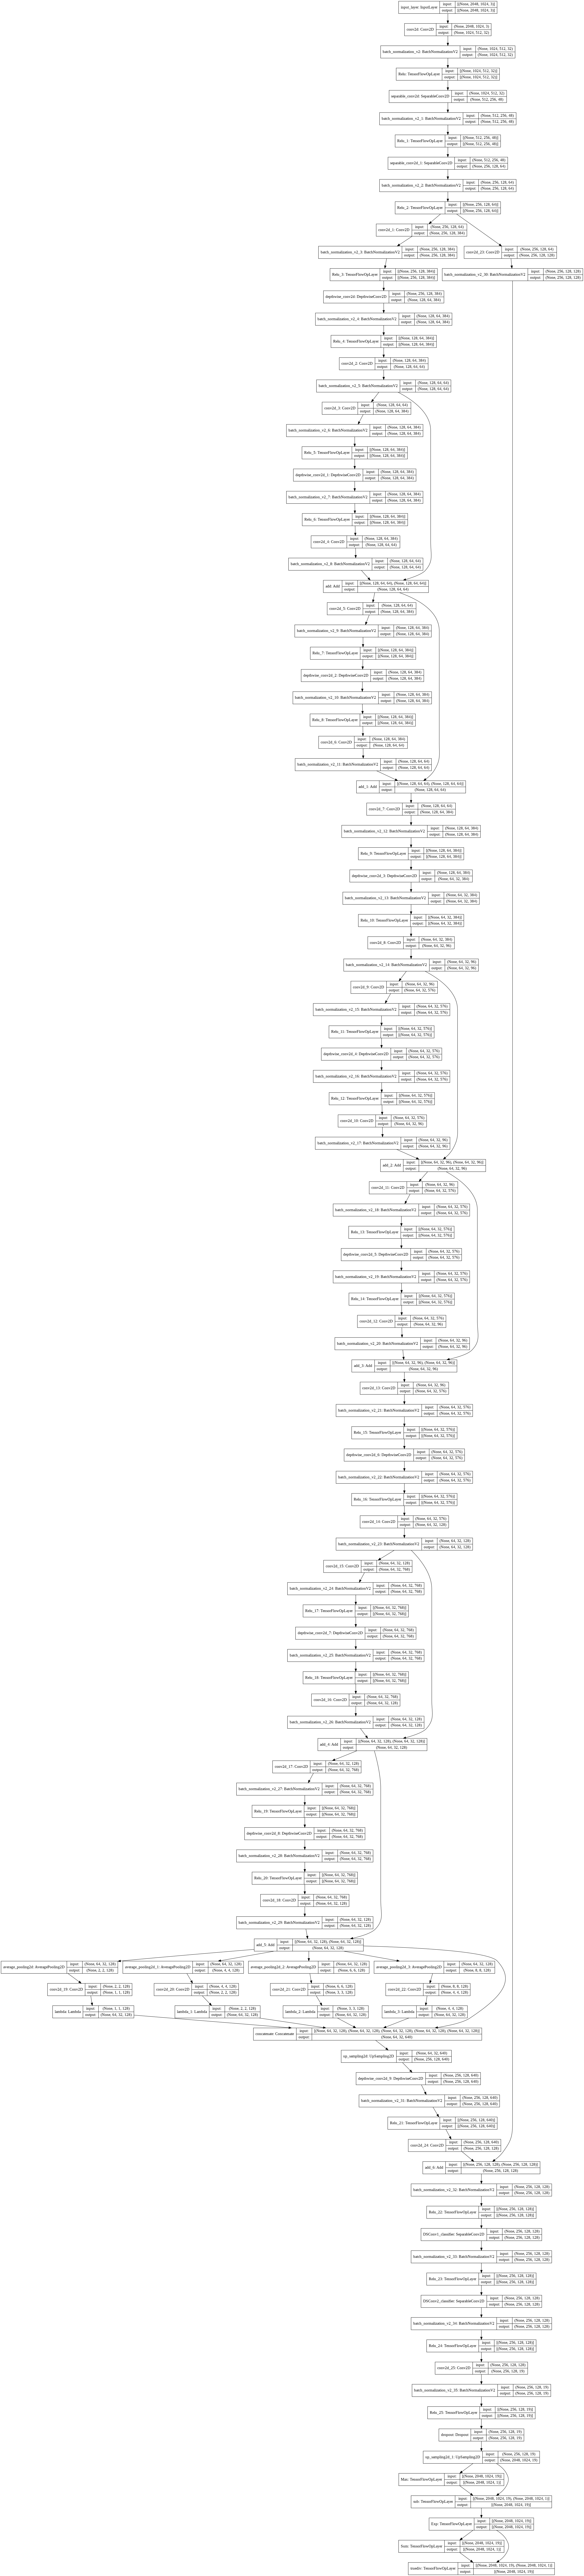

In [20]:
tf.keras.utils.plot_model(fast_scnn, show_layer_names=True, show_shapes=True)

